In [145]:
# import libraries
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime as dt 
import numpy as np

**Challenges with Using OES Data**

1. **Changes in Occupational Classification:** 
The Standard Occupational Classification (SOC) changed in different periods: old SOC (through 1998), 2000 SOC, 2010 SOC, and 2017 SOC. Certain occupations have been aggregated and condensed in different ways from the 2010 SOC to the 2017 SOC. Details here: https://www.bls.gov/oes/changes_2017.htm. Luckily, none of these changes seem to have affected the Finance and Insurance industry from the years 2010-2019. Thus, we can eliminate this worry for this specific industry. **WILL NEED TO CHECK THIS FOR NEW INDUSTRIES**


2. **Changes in Industrial Classification:**
The NAICS classifications for different indistries has changed over time, which the OES follows. https://www.bls.gov/oes/changes_2017.htm. Unfortunately, NAICS code 523 became more refined in May 2017, with different jobs within the securities and commodity contracts jobs being more finely detailed. Otherwise, there are not any other aggregations in the 2017 issue that would affect this. There have also been changes in classification in 2008, 2012, and 2017. I will need to check for this for different occupations and ensure that their classification has not changed between 2008-2019 and if so, aggregate accordingly. 


3. **Changes in Geographical Classification:**
These are changes regarding geographical metrics that can be found in the OES data. This does not concern my analysis right now, but if it does, then I will have to revisit this point. 


4. **Changes in the Survey Reference Period:**
In 2002, the reference months for the OES survey were changed from October, November, and December to May and November in order to reduce seasonal influences. Industries or occupations that have seasonal employment variations between the two sets of reference months will show employment shifts due to the change in the time of year the data were collected. Since I am only looking at a time frame between 2008 and 2019, this should not be a concern. 


5. **Changes in mean wage estimation methodology:**
In 2002, the method of calculating mean wages was changed for occupations with any workers earning above 70 dollars per hour in order to remove a downward bias in mean wage estimates. The result of this change may be seen as higher mean wage estimates for some occupations. However, the median and percentile wage estimates would not be affected by this change. Again, since I am only looking at a time frame between 2008 and 2019, this should not be a concern. 


6. **Permanent features of OES methodology:**
It is difficult to make comparisons of OES data across short time periods due to the moving-average window approach over a 3-year period to make estimates. However, I am looking at estimates over a 10-year period, so this should not be a large concern. 


**Assuming that the above 6 caveats with the OES data are addressed, it should be safe to use the survey data to construct multiple time series for analysis**

First, I will take a look at the ONET* classification codes for occupations in the Finance and Insurance Industries. I will use these codes to get only the occupations that fall into one of these codes. 

In [8]:
onet_df = pd.read_csv("data/onet_finance_and_insurance.csv")
onet_df

,Employed by this Industry,Code,Occupation,Projected Growth (2018-2028),Projected Job Openings (2018-2028)
0,98%,43-3071.00,Tellers,Decline,47600.0
1,94%,43-4141.00,New Accounts Clerks,Decline,4400.0
2,93%,13-2053.00,Insurance Underwriters,Decline,8400.0
3,93%,13-1032.00,"Insurance Appraisers, Auto Damage",Average,1600.0
4,92%,43-4011.00,Brokerage Clerks,Average,6200.0
...,...,...,...,...,...
74,10%,15-2041.00,Statisticians,Much faster than average,5300.0
75,NaN,15-2041.01,Biostatisticians,NaN,NaN
76,NaN,15-2041.02,Clinical Data Managers,NaN,NaN
77,10%,11-3131.00,Training and Development Managers,Faster than average,3800.0


I will be using the Code column above and cleaning it up a bit. I will be removing the decimal places from each of the codes. Even though some of the occupations are specified further by their decimal codes (ie. Biostatisticians are 15-2014.01) in the ONET* data, the OES data generalizes these codes by dropping the decimal places. I believe it will be better to aggregate by these generalized codes in order to fit the construction of a time series better.

In [14]:
onet_codes = list(onet_df['Code'])
onet_codes = [x[:-3] for x in onet_codes]

In [46]:
# pass in the relative path (string), year (int) 
def fetch_filter_merge(timeseries_df, rel_path, year):
    full_path = 'data/oes_data/' + rel_path
    
    # read in dataset 
    curr_df = pd.read_excel(full_path)
    
    # lowercase the column names 
    curr_df.columns = curr_df.columns.str.lower()
    
    # filter out unrelated occupations 
    curr_df = curr_df[curr_df['occ_code'].isin(onet_codes)]
    
    # get only columns of interest
    curr_df = curr_df[['occ_code', 'a_mean', 'h_mean', 'tot_emp']]
    
    # add years to specific column names
    add_year = ['tot_emp', 'h_mean', 'a_mean']
    new_columns = []
    for col in curr_df.columns:
        if (col in add_year): 
            col = col + '_' + str(year)
        
        new_columns.append(col)
        
    curr_df.columns = new_columns 
        
    # merge with the current dataframe for the time series
    timeseries_df = pd.merge(timeseries_df, curr_df, on='occ_code', how='inner')
    
    # return both the cleaned df and the merged df 
    
    return curr_df, timeseries_df

In [47]:
# process the first year's df
df_2008 = pd.read_excel('data/oes_data/oesm08nat/national_2008.xls')
df_2008 = df_2008[['occ_code', 'occ_title', 'a_mean', 'h_mean', 'tot_emp']]

add_year = ['tot_emp', 'h_mean', 'a_mean']
new_columns = []
for col in df_2008.columns:
    if (col in add_year): 
        col = col + '_' + '2008'
        
    new_columns.append(col)
        
df_2008.columns = new_columns 

timeseries_df = df_2008
timeseries_df

,occ_code,occ_title,a_mean_2008,h_mean_2008,tot_emp_2008
0,00-0000,All Occupations,42270,20.32,135185230
1,11-0000,Management occupations,100310,48.23,6152650
2,11-1011,Chief executives,160440,77.13,301930
3,11-1021,General and operations managers,107970,51.91,1697690
4,11-1031,Legislators,37980,*,64650
...,...,...,...,...,...
818,53-7073,Wellhead pumpers,39430,18.96,17050
819,53-7081,Refuse and recyclable material collectors,32790,15.76,129080
820,53-7111,Shuttle car operators,42700,20.53,3050
821,53-7121,"Tank car, truck, and ship loaders",39510,19.00,12330


In [48]:
# Create dfs for all years and create the timeseries df 
rel_path = 'oesm09nat/national_2009.xls'
df_2009, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2009)

rel_path = 'oesm10nat/national_2010.xls'
df_2010, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2010)

rel_path = 'oesm11nat/national_2011.xls'
df_2011, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2011)

rel_path = 'oesm12nat/national_2012.xls'
df_2012, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2012)

rel_path = 'oesm13nat/national_2013.xls'
df_2013, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2013)

rel_path = 'oesm14nat/national_2014.xlsx'
df_2014, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2014)

rel_path = 'oesm15nat/national_2015.xlsx'
df_2015, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2015)

rel_path = 'oesm16nat/national_2016.xlsx'
df_2016, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2016)

rel_path = 'oesm17nat/national_2017.xlsx'
df_2017, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2017)

rel_path = 'oesm18nat/national_2018.xlsx'
df_2018, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2018)

rel_path = 'oesm19nat/national_2019.xlsx'
df_2019, timeseries_df = fetch_filter_merge(timeseries_df, rel_path, 2019)

In [49]:
timeseries_df

,occ_code,occ_title,a_mean_2008,h_mean_2008,tot_emp_2008,a_mean_2009,h_mean_2009,tot_emp_2009,a_mean_2010,h_mean_2010,...,tot_emp_2016,a_mean_2017,h_mean_2017,tot_emp_2017,a_mean_2018,h_mean_2018,tot_emp_2018,a_mean_2019,h_mean_2019,tot_emp_2019
0,11-2021,Marketing managers,118160,56.81,166790,120070,57.73,169330,122720,59,...,205900,145620,70.01,218970,147240,70.79,240440,149200,71.73,263680
1,11-3021,Computer and information systems managers,118710,57.07,276820,120640,58.00,287210,123280,59.27,...,352510,149730,71.99,365690,152860,73.49,391430,156390,75.19,433960
2,11-3031,Financial managers,110640,53.19,500590,113730,54.68,495180,116970,56.24,...,543300,143530,69.01,569380,146830,70.59,608120,147530,70.93,654790
3,13-1031,"Claims adjusters, examiners, and investigators",57550,27.67,277230,58780,28.26,273930,60200,28.94,...,274420,66340,31.89,282030,67540,32.47,287730,68940,33.15,287960
4,13-1032,"Insurance appraisers, auto damage",53980,25.95,11280,56180,27.01,10960,57710,27.75,...,15130,64680,31.1,16150,65510,31.5,15200,66240,31.85,13750
5,13-1041,"Compliance officers, except agriculture, const...",53760,25.85,242270,55100,26.49,247900,62140,29.88,...,273910,71540,34.39,287130,72520,34.86,300900,72850,35.03,317600
6,13-1111,Management analysts,82920,39.87,535850,84650,40.70,552770,87260,41.95,...,637690,93440,44.92,659200,94390,45.38,684470,95560,45.94,709750
7,13-2041,Credit analysts,64580,31.05,74400,67230,32.32,67950,68180,32.78,...,72930,82900,39.86,74850,82300,39.57,74820,84930,40.83,73930
8,13-2052,Personal financial advisors,92970,44.69,146690,94180,45.28,149460,91220,43.85,...,201850,124140,59.68,200920,121770,58.54,200260,119290,57.35,210190
9,13-2053,Insurance underwriters,62600,30.09,98690,63330,30.45,98430,65220,31.35,...,91650,77660,37.34,89910,76880,36.96,96040,77640,37.33,100050


In [50]:
def build_timeseries(df, occ): 
    occupation = df[df['occ_code'] == occ]
    
    total_emp = [] 
    hourly_mean_wage = []
    annual_mean_wage = []
    
    for col in list(occupation.columns): 
        var = str(col[:-5])
        if (var == 'tot_emp'): 
            total_emp.append(occupation.iloc[0][col])
        elif (var == 'h_mean'): 
            hourly_mean_wage.append(occupation.iloc[0][col])
        elif (var == 'a_mean'): 
            annual_mean_wage.append(occupation.iloc[0][col])

    
    return total_emp, hourly_mean_wage, annual_mean_wage

ca_emp, ca_hrly, ca_ann = build_timeseries(timeseries_df, '13-2041')

In [51]:
ca_emp

[74400,
 67950,
 62680,
 59140,
 61240,
 66490,
 69390,
 70840,
 72930,
 74850,
 74820,
 73930]

In [148]:
ts_occ = timeseries_df.T
ts_occ.columns = ts_occ.iloc[0]
ts_occ = ts_occ.iloc[1:, :]
ts_occ = ts_occ.reset_index()
ts_occ = ts_occ.rename(columns={'index': "occ_code"})
ts_occ.head()

occ_code,occ_code,11-2021,11-3021,11-3031,13-1031,13-1032,13-1041,13-1111,13-2041,13-2052,...,43-4041,43-4051,43-4131,43-4141,43-6011,43-9021,43-9041,43-9051,43-9071,43-9111
0,occ_title,Marketing managers,Computer and information systems managers,Financial managers,"Claims adjusters, examiners, and investigators","Insurance appraisers, auto damage","Compliance officers, except agriculture, const...",Management analysts,Credit analysts,Personal financial advisors,...,"Credit authorizers, checkers, and clerks",Customer service representatives,Loan interviewers and clerks,New accounts clerks,Executive secretaries and administrative assis...,Data entry keyers,Insurance claims and policy processing clerks,"Mail clerks and mail machine operators, except...","Office machine operators, except computer",Statistical assistants
1,a_mean_2008,118160,118710,110640,57550,53980,53760,82920,64580,92970,...,31980,31790,33890,30990,42340,27110,34830,26420,27310,36020
2,h_mean_2008,56.81,57.07,53.19,27.67,25.95,25.85,39.87,31.05,44.69,...,15.37,15.28,16.29,14.90,20.35,13.04,16.75,12.70,13.13,17.32
3,tot_emp_2008,166790,276820,500590,277230,11280,242270,535850,74400,146690,...,65020,2233270,212340,87300,1491520,272810,237800,137350,79470,16900
4,a_mean_2009,120070,120640,113730,58780,56180,55100,84650,67230,94180,...,33700,32410,34670,31490,44010,28000,35740,27150,28060,37500


In [147]:
a_mean_df = ts_occ[(ts_occ['occ_code'].str.contains('a_mean')) | (ts_occ['occ_code'].str.contains('occ_title'))]
a_mean_df.columns = [a_mean_df.columns, a_mean_df.iloc[0, :].values]
a_mean_df = a_mean_df.iloc[1:]
a_mean_df['year'] = np.arange(2008, 2020, 1)
a_mean_df

occ_code,occ_code,11-2021,11-3021,11-3031,13-1031,13-1032,13-1041,13-1111,13-2041,13-2052,...,43-4051,43-4131,43-4141,43-6011,43-9021,43-9041,43-9051,43-9071,43-9111,year
,occ_title,Marketing managers,Computer and information systems managers,Financial managers,"Claims adjusters, examiners, and investigators","Insurance appraisers, auto damage","Compliance officers, except agriculture, construction, health and safety, and transportation",Management analysts,Credit analysts,Personal financial advisors,...,Customer service representatives,Loan interviewers and clerks,New accounts clerks,Executive secretaries and administrative assistants,Data entry keyers,Insurance claims and policy processing clerks,"Mail clerks and mail machine operators, except postal service","Office machine operators, except computer",Statistical assistants,
1,a_mean_2008,118160,118710,110640,57550,53980,53760,82920,64580,92970,...,31790,33890,30990,42340,27110,34830,26420,27310,36020,2008
4,a_mean_2009,120070,120640,113730,58780,56180,55100,84650,67230,94180,...,32410,34670,31490,44010,28000,35740,27150,28060,37500,2009
7,a_mean_2010,122720,123280,116970,60200,57710,62140,87260,68180,91220,...,32780,35180,31540,45860,28400,36390,27530,28610,37090,2010
10,a_mean_2011,126190,125660,120450,61110,59080,63760,87980,69640,90900,...,33120,35810,32360,48120,29010,36850,28010,29190,40540,2011
13,a_mean_2012,129870,129130,123260,61530,60230,64960,88070,69500,90820,...,33110,36180,32950,50220,29220,37300,28140,29580,41010,2012
16,a_mean_2013,133700,132570,126660,62340,63100,66770,89990,72590,99920,...,33370,36940,33940,51870,29670,38010,28760,29710,42530,2013
19,a_mean_2014,137400,136280,130230,63500,64750,68000,90860,75970,108090,...,33890,38120,34890,53590,30130,38740,29160,30200,42990,2014
22,a_mean_2015,140660,141000,134330,64300,65300,69180,91770,79720,118050,...,34560,39210,35820,55460,30810,39560,29930,30980,44220,2015
25,a_mean_2016,144140,145740,139720,64990,65930,70250,91910,81160,123100,...,35170,40300,36480,57910,31640,40780,30580,32390,48300,2016


In [150]:
h_mean_df = ts_occ[(ts_occ['occ_code'].str.contains('h_mean')) | (ts_occ['occ_code'].str.contains('occ_title'))]
h_mean_df.columns = [h_mean_df.columns, h_mean_df.iloc[0, :].values]
h_mean_df = h_mean_df.iloc[1:]
h_mean_df['year'] = np.arange(2008, 2020, 1)
h_mean_df

occ_code,occ_code,11-2021,11-3021,11-3031,13-1031,13-1032,13-1041,13-1111,13-2041,13-2052,...,43-4051,43-4131,43-4141,43-6011,43-9021,43-9041,43-9051,43-9071,43-9111,year
,occ_title,Marketing managers,Computer and information systems managers,Financial managers,"Claims adjusters, examiners, and investigators","Insurance appraisers, auto damage","Compliance officers, except agriculture, construction, health and safety, and transportation",Management analysts,Credit analysts,Personal financial advisors,...,Customer service representatives,Loan interviewers and clerks,New accounts clerks,Executive secretaries and administrative assistants,Data entry keyers,Insurance claims and policy processing clerks,"Mail clerks and mail machine operators, except postal service","Office machine operators, except computer",Statistical assistants,
2,h_mean_2008,56.81,57.07,53.19,27.67,25.95,25.85,39.87,31.05,44.69,...,15.28,16.29,14.90,20.35,13.04,16.75,12.70,13.13,17.32,2008
5,h_mean_2009,57.73,58.00,54.68,28.26,27.01,26.49,40.70,32.32,45.28,...,15.58,16.67,15.14,21.16,13.46,17.18,13.05,13.49,18.03,2009
8,h_mean_2010,59,59.27,56.24,28.94,27.75,29.88,41.95,32.78,43.85,...,15.76,16.91,15.17,22.05,13.65,17.49,13.23,13.76,17.83,2010
11,h_mean_2011,60.67,60.41,57.91,29.38,28.41,30.66,42.3,33.48,43.7,...,15.92,17.21,15.56,23.13,13.95,17.72,13.47,14.03,19.49,2011
14,h_mean_2012,62.44,62.08,59.26,29.58,28.96,31.23,42.34,33.42,43.66,...,15.92,17.4,15.84,24.14,14.05,17.93,13.53,14.22,19.72,2012
17,h_mean_2013,64.28,63.74,60.89,29.97,30.34,32.1,43.26,34.9,48.04,...,16.04,17.76,16.32,24.94,14.27,18.27,13.83,14.29,20.45,2013
20,h_mean_2014,66.06,65.52,62.61,30.53,31.13,32.69,43.68,36.52,51.97,...,16.29,18.33,16.77,25.76,14.48,18.63,14.02,14.52,20.67,2014
23,h_mean_2015,67.63,67.79,64.58,30.91,31.39,33.26,44.12,38.33,56.76,...,16.62,18.85,17.22,26.66,14.81,19.02,14.39,14.9,21.26,2015
26,h_mean_2016,69.3,70.07,67.17,31.24,31.7,33.77,44.19,39.02,59.18,...,16.91,19.37,17.54,27.84,15.21,19.61,14.7,15.57,23.22,2016


In [152]:
emp_df = ts_occ[(ts_occ['occ_code'].str.contains('emp')) | (ts_occ['occ_code'].str.contains('occ_title'))]
emp_df.columns = [emp_df.columns, emp_df.iloc[0, :].values]
emp_df = emp_df.iloc[1:]
emp_df['year'] = np.arange(2008, 2020, 1)
emp_df

occ_code,occ_code,11-2021,11-3021,11-3031,13-1031,13-1032,13-1041,13-1111,13-2041,13-2052,...,43-4051,43-4131,43-4141,43-6011,43-9021,43-9041,43-9051,43-9071,43-9111,year
,occ_title,Marketing managers,Computer and information systems managers,Financial managers,"Claims adjusters, examiners, and investigators","Insurance appraisers, auto damage","Compliance officers, except agriculture, construction, health and safety, and transportation",Management analysts,Credit analysts,Personal financial advisors,...,Customer service representatives,Loan interviewers and clerks,New accounts clerks,Executive secretaries and administrative assistants,Data entry keyers,Insurance claims and policy processing clerks,"Mail clerks and mail machine operators, except postal service","Office machine operators, except computer",Statistical assistants,
3,tot_emp_2008,166790,276820,500590,277230,11280,242270,535850,74400,146690,...,2233270,212340,87300,1491520,272810,237800,137350,79470,16900,2008
6,tot_emp_2009,169330,287210,495180,273930,10960,247900,552770,67950,149460,...,2195860,195310,81650,1361170,243550,235480,131750,70230,15900,2009
9,tot_emp_2010,164590,288660,478940,262540,10280,204000,536310,62680,155360,...,2146120,181600,67170,1132070,219530,231570,119960,66580,15490,2010
12,tot_emp_2011,168410,300830,477690,263810,10950,210510,538950,59140,161790,...,2212820,186240,60830,952030,211200,218630,115010,66280,14780,2011
15,tot_emp_2012,171430,309740,484910,263280,11770,227500,540440,61240,175470,...,2299750,192010,55320,803040,207280,226260,102410,66820,14870,2012
18,tot_emp_2013,174010,319080,499320,275500,13180,236090,567840,66490,183420,...,2389580,213270,56990,755210,207660,236160,99140,66840,15640,2013
21,tot_emp_2014,184490,330360,518030,266280,13690,246970,587450,69390,196490,...,2511130,212440,52260,713730,205950,252670,99190,66530,14110,2014
24,tot_emp_2015,192890,341250,531120,271600,15270,257010,614110,70840,197580,...,2595990,216380,48970,666490,199240,262910,95640,63290,13510,2015
27,tot_emp_2016,205900,352510,543300,274420,15130,273910,637690,72930,201850,...,2707040,224340,41630,631610,194810,274350,91530,58160,10900,2016


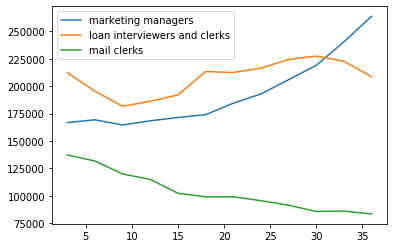

In [96]:
plt.plot(emp_df['11-2021'][1:], label='marketing managers')
plt.plot(emp_df['43-4131'][1:], label='loan interviewers and clerks')
plt.plot(emp_df['43-9051'][1:], label='mail clerks')
plt.legend()

In [153]:
# save all 4 dataframes to csv 

ts_occ.to_csv("data/bls_all_occs_attributes.csv")
a_mean_df.to_csv("data/bls_a_mean_series.csv")
h_mean_df.to_csv("data/bls_h_mean_series.csv")
emp_df.to_csv("data/bls_emp_series.csv")